<a href="https://colab.research.google.com/github/KimchiLim/Bayesian-Optimization/blob/main/Bayesian_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class BayesianOptimizer:
  """
  BayesianOptimizer (class):
    Attributes:
      - function: Blackbox function which we are trying to optimize. Invisible to
                  the optimizer outside of point evaluations (no gradients)
      - bounds:   Limits on the parameters
    Methods:
      - optimize: Estimate the minimum/maximum of the function. Should take as
                  parameters the number of iterations, and the kernel (maybe).
      - show:     Print some kind of visual of the optimization.

  """
  def __init__(self, f, bounds, kernel, granularity=100, k=1.96):
    self.f = f
    self.bounds = bounds
    self.kernel = kernel
    self.granularity = granularity
    self.k = k
    self.samples = None
    self.data = None
    self.ucb = None
    self.var = None
    self.max = -np.inf
    self.mean = None

  def optimize(self, n, epochs):
    """
    Optimize by sampling n points according to some simple sampling heuristic,
    then sampling 'epoch' points according to the Bayesian Optimization algorithm
    """
    # Sample n points spaced evenly in the search space
    self.samples = np.linspace(self.bounds[0], self.bounds[1], n)
    self.data = np.array([self.f(x) for x in self.samples])
    self.max = max(self.data)

    covariance = np.array([[self.kernel(x, y) for y in self.samples] for x in self.samples])
    covariance = covariance + 0.0001 * np.eye(n) # To avoid colinearity
    covariance_inv = np.linalg.inv(covariance)
    # Utilize constant mean function
    mu = np.mean(self.data)
    # Candidates spaced evenly in search space
    candidates = np.linspace(self.bounds[0], self.bounds[1], self.granularity)
    cov_vectors = np.array([
        [self.kernel(candidate, x) for x in self.samples] for candidate in candidates
    ])
    # Calculate mean and variance of candidates
    self.mean = np.array([
        cov_vectors[i]
        @ covariance_inv
        @ (self.data - mu).reshape((len(self.data), 1))
        + mu
        for i in range(self.granularity)
    ]).flatten()
    self.var = np.array([
        self.kernel(candidate, candidate)
        - cov_vectors[i]
        @ covariance_inv
        @ cov_vectors[i].reshape((len(cov_vectors[i]), 1))
        for i, candidate in enumerate(candidates)
    ]).flatten()

    # Construct 95% confidence interval
    self.ucb = self.mean + self.k * np.sqrt(self.var)

    for _ in range(epochs):

      # Sample point with greatest upper confidence bound
      new_sample = candidates[np.argmax(self.ucb)]
      new_data = self.f(new_sample)

      self.samples = np.append(self.samples, new_sample)
      self.data = np.append(self.data, new_data)
      self.max = max(self.max, new_data)

      covariance = np.array([[self.kernel(x, y) for y in self.samples] for x in self.samples])
      covariance = covariance + 0.0001 * np.eye(n+1+_)
      covariance_inv = np.linalg.inv(covariance)
      mu = np.mean(self.data)
      candidates = np.linspace(self.bounds[0], self.bounds[1], self.granularity)
      cov_vectors = np.array([
          [self.kernel(candidate, x) for x in self.samples] for candidate in candidates
      ])
      self.mean = np.array([
          cov_vectors[i]
          @ covariance_inv
          @ (self.data - mu).reshape((len(self.data), 1))
          + mu
          for i in range(self.granularity)
      ]).flatten()
      self.var = np.array([
          self.kernel(candidate, candidate)
          - cov_vectors[i]
          @ covariance_inv
          @ cov_vectors[i].reshape((len(cov_vectors[i]), 1))
          for i, candidate in enumerate(candidates)
      ]).flatten()

      self.ucb = self.mean + self.k * np.sqrt(self.var)

    return self.max

  def show(self):
    x = np.linspace(self.bounds[0], self.bounds[1], 100)
    plt.plot(x, self.f(x), 'b-', label='Black Box Function')
    plt.plot(self.samples, self.data, 'ro')
    plt.plot(np.linspace(self.bounds[0], self.bounds[1], self.granularity), self.ucb, 'g--', label='95% Confidence Interval')
    plt.plot(np.linspace(self.bounds[0], self.bounds[1], self.granularity), 2 * self.mean - self.ucb, 'g--')
    plt.plot(np.linspace(self.bounds[0], self.bounds[1], self.granularity), self.mean, 'r--', label='Black Box Approximation')
    plt.legend(loc='upper right')
    print(f"Maximum value achieved: ({self.samples[np.argmax(self.data)]}, {self.max})")
    return

Maximum value achieved: (-3.0, 8.749440499711767)


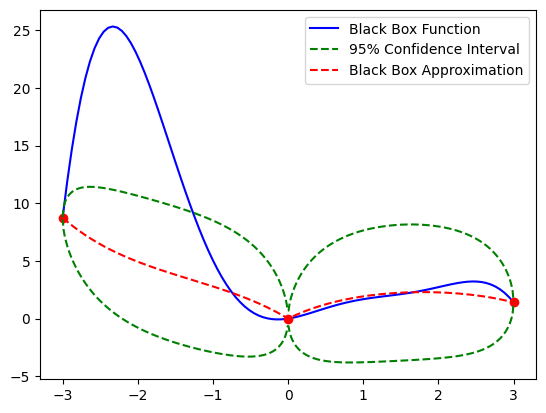

In [ ]:
def blackbox(x):
  return (x ** 3 - 3 * x ** 2 + 3 * x + 1) * np.sin(x)

def kernel(x, y):
  return 10 * np.exp(-abs(x - y))

optimizer = BayesianOptimizer(blackbox, [-3, 3], kernel, granularity=500)
optimizer.optimize(3, 0)
optimizer.show()